In [1]:
!pip install einops
!pip install git+https://github.com/huggingface/transformers
!pip install gradio==4.15.0
!pip install ngrok

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.6 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8dsc91w6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8dsc91w6
  Resolved https://github.com/huggingface/transformers to commit 3f69f415adcbdaedec154ba8eac220ef3276975d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8404406 sha256=44202a5e6b29308d379a68f8b28b751cf9f04ad1926fe64a3af591be6059887f
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ccm3m0b/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151

In [2]:
import random
import torch
import copy
import types
import traceback
import ngrok
import asyncio

import pandas as pd

from tqdm.notebook import tqdm

from gensim.test.utils import datapath

from scipy.stats import pearsonr, spearmanr

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

from kaggle_secrets import UserSecretsClient

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Demo Deploy

In [ ]:
def deploy_gradio(interface):
    listener = ngrok.forward(addr="http://localhost:7860", authtoken=UserSecretsClient().get_secret("ngrok_key"))
    await asyncio.wait_for(listener, timeout=10)
    public_url = listener.result().url()
    print(f"Please click on the text below {public_url}")
    interface.launch(share=False, prevent_thread_lock=True, show_error=True)
    return listener

# Import Models

In [3]:
device = "cuda"
torch.set_default_device(device)

In [4]:
raw_phi = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
tokenizer_phi = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
config_phi = AutoConfig.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

raw_phi = raw_phi.eval()
raw_phi.zero_grad()

config.json:   0%|          | 0.00/869 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [5]:
raw_gpt = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
config_gpt = AutoConfig.from_pretrained("gpt2", trust_remote_code=True)

raw_gpt.eval()
raw_gpt.zero_grad()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
class ModelWrapper:
    def __init__(self, name, model, tokenizer=None, access_options={}):
        self.__dict__["name"] = name
        self.__dict__["model"] = model
        self.__dict__["tokenizer"] = tokenizer
        self.__dict__["access_options"] = access_options

    def __getattr__(self, name):
        if name in self.__dict__["access_options"]:
            opt = self.__dict__["access_options"][name]
            obj = self.__dict__["model"]
            if "pre" in opt:
                obj = opt["pre"](obj)
            obj = getattr(obj, opt["get"])
            if isinstance(obj, types.MethodType): obj = obj()
            return obj
        return getattr(self.__dict__["model"], name)

    def __setattr__(self, name, value):
        if name in self.__dict__["access_options"]:
            opt = self.__dict__["access_options"][name]
            obj = self.__dict__["model"]
            if "pre" in opt:
                obj = opt["pre"](obj)
            if isinstance(obj, types.MethodType): obj = obj()
            return setattr(obj, opt["set"], value) 
        return setattr(self.__dict__["model"], name, value)

In [7]:
phi = ModelWrapper("Phi 1.5", raw_phi, tokenizer=tokenizer_phi, access_options={
    "transformer": {"get": "model", "set": "model"}, 
    "layers": {"get": "layers", "set": "layers", "pre": lambda x: x.get_decoder()},
    "input_embeddings": {"get": "embed_tokens", "set": "embed_tokens", "pre": lambda x: x.get_decoder()},
    "layer_norm": {"get": "final_layernorm", "set": "final_layernorm", "pre": lambda x: x.get_decoder()}
})

gpt = ModelWrapper("GPT 2", raw_gpt, tokenizer=tokenizer_gpt, access_options={
    "transformer": {"get": "transformer", "set": "transformer"}, 
    "layers": {"get": "h", "set": "h", "pre": lambda x: x.transformer},
    "input_embeddings": {"get": "wte", "set": "wte", "pre": lambda x: x.transformer},
    "layer_norm": {"get": "ln_f", "set": "ln_f", "pre": lambda x: x.transformer}
})

# Define Helper Functions

## 

## Model Reduction

In [8]:
def model_reduction(model: ModelWrapper, max_layer=0, remove_norm=True, reset=False):
    raw_model = model.model
    if not hasattr(raw_model, '_original_layers'):
        raw_model._original_layers = model.layers
    if not hasattr(raw_model, '_layer_norm'):
        raw_model._layer_norm = model.layer_norm
    if reset:
        model.layers = raw_model._original_layers
        model.layer_norm = raw_model._layer_norm
        return
    current_list = model.layers
    new_list = torch.nn.ModuleList()
    for i, layer in enumerate(current_list):
        if i > max_layer:
            break
        new_list.append(layer)
    model.layers = new_list
    if remove_norm:
        model.layer_norm = torch.nn.Identity()

In [9]:
def generate_layer_embeddings(model, layers, split_size=10000):
    n = model.get_input_embeddings().num_embeddings
    d = model.get_input_embeddings().embedding_dim 
    layers_emb = [torch.nn.Embedding(n, d) for _ in layers]
    model_reduction(model, max(layers), remove_norm=True)
    try:
        indexes = torch.tensor([[i] for i in range(0, n)])
        chunked_indexes = torch.split(indexes, split_size)
        emb_matrix = torch.Tensor().cpu()
        with torch.no_grad():
            for indexes in chunked_indexes:
                t = torch.stack([model.transformer.forward(indexes, output_hidden_states=True).hidden_states[layer].detach().cpu() for layer in layers]).cpu()
                emb_matrix = torch.cat((emb_matrix, t), 1)
                torch.cuda.empty_cache()
            for layer in layers:
                layers_emb[layer].weight = torch.nn.Parameter(emb_matrix[layer].squeeze().cuda())
            del emb_matrix
    except Exception as error:
        print("An error occurred: ", error)
        traceback.print_exc()
    torch.cuda.empty_cache()
    model_reduction(model, reset=True)
    return layers_emb

## Embedding Computations

In [10]:
def multiencode(tok, words, return_tensors="pt"):
    if (isinstance(words, list) or isinstance(words, tuple)) and not isinstance(words, str):
        return torch.cat([tok.encode(word, return_tensors="pt") for word in words], dim=-1)
    else:
        return tok.encode(words, return_tensors="pt")
    
def avgencode(emb, word, tok=None, avg=True):
    source = word
    # If input is a string tokenize it
    if (isinstance(word, str) or isinstance(word[0], str)) and tok is not None:
        word = emb(multiencode(tok, word))
    # Calculate average if avg flag is true and if it is needed
    if word.shape[1] != 1 and avg:
        word = torch.unsqueeze(torch.mean(word, dim=1), dim=1)
    elif word.shape[1] != 1 and not avg:
        raise Exception(f"{source} is not a single token: {word}")
    return word

In [11]:
def calc_distance(emb, word1, word2, tok=None, avg=True, dist="cosine", multi=False):
    # Encode and average (if multi is True, word1 represents the embedding matrix)
    if not multi:
        word1 = avgencode(emb, word1, tok, avg=avg)
    word2 = avgencode(emb, word2, tok, avg=avg)
    # Compute distances
    if dist == "L2":
        distances = torch.norm(word1 - word2, dim=2)
    elif dist == "cosine":
        cs = torch.nn.CosineSimilarity(dim=2)
        distances = 1 - cs(word1, word2)
    else:
        raise Exception("Unknown distance")
    return distances

def get_closest_emb(emb, word, k=1, decode=True, tok=None, avg=True, dist="cosine"):
    # Compute distances
    distances = calc_distance(emb, emb.weight.data, word, tok=tok, avg=avg, dist=dist, multi=True)
    # Compute top k smalles indices
    topk = torch.squeeze(torch.topk(distances, k=k, largest=False).indices)
    # If one element, unsqueeze it
    if k == 1:
        topk = torch.unsqueeze(topk, dim=0)
    # Decode closest k
    if decode and tok is not None:
        topk = [tok.decode(c) for c in topk.tolist()]
    return topk

def emb_arithmetic(emb, tok, words, k=1, avg=True, dist="cosine"):
    # Encode and average
    words_emb = [avgencode(emb, word, tok, avg=avg) for word in words]
    # Compute embeddings
    w1 = words_emb[0]
    w2 = words_emb[1]
    w3 = words_emb[2]
    # Do embedding arithmetic
    if dist == "L2":
        w = torch.nn.functional.normalize(w1 - w2 + w3, dim=0)
    else:
        w = w1 - w2 + w3
    # Get closest k
    closest = get_closest_emb(emb, w, k=k, decode=True, tok=tok, dist=dist)
    return (w, closest)

def print_results(res):
     for i, r in enumerate(res):
        print(f"{i+1}) {r}")

In [12]:
def batch_emb_arithmetic(emb, tok, queries, k=5, avg=True, dist="cosine", out=True):
    ret = []
    for q in queries:
        if out:
            print("##########################")
            # Print title
            title_q = q
            if not isinstance(q[0], str):
                title_q = [qq[0] for qq in q]
            print(f"{title_q[0]} - {title_q[1]} + {title_q[2]} =")
        # Compute and print results
        res = emb_arithmetic(emb, tok, q, k=k, avg=avg, dist=dist)
        if out:
            print_results(res[1])
        ret.append(res)
    return ret

def evaluate_batch(results, solutions, out=True, score="rankscore", k=None):
    
    def get_rank(r, s, out=0):
        try:
            return r.index(s)
        except ValueError:
            return out
    
    n = len(results[0][1])
    ev = []
    for res, sol in zip(list(map(lambda x: x[1], results)), solutions):
        # Get rank of each solution for each result outputs
        ranks = [get_rank(res, s, out=n) for s in sol]
        # Append best rank to final evaluation list
        ev.append(min(ranks))
    # Return score
    if score == "rankscore":
        score = 1 - ( sum(ev) / (n * len(solutions)) )
    elif score == "topk":
        if not k:
            raise Exception(f"Invalid k for topk")
        score = len([i for i in ev if i < k]) / len(ev)
    else:
        raise Exception(f"Unknown Score")
    if out:
        print(f"{ev} -> {score}")
    return score

In [13]:
def test_arithmetic(models, questions, reduced_model_layers=[0], k=100):
    results = {}
    for model in tqdm(models):
        model_name = model.name
        model_tokenizer = model.tokenizer
        print(f"Computing model {model_name}")
        results[model_name] = {}
        reduced_embeddings = generate_layer_embeddings(model, reduced_model_layers)
        for question_name, question in questions.items():
            question, solution = question
            results[model_name][question_name] = {top_layer: batch_emb_arithmetic(reduced_embeddings[top_layer], model_tokenizer, question, k=k, out=False) for top_layer in reduced_model_layers}
    return results

# Test

In [14]:
capital_arithmetic = [
    ["Rome Rome", "Italy Italy", "France France"],
    ["Rome Rome", "Italy Italy", "Australia Australia"],
    ["Paris Paris", "France France", "Italy Italy"],
    ["Paris Paris", "France France", "Australia Australia"],
    ["Canberra Canberra", "Australia Australia", "Italy Italy"],
    ["Canberra Canberra", "Australia Australia", "France France"],
]
capital_single = [
    [" Rome", " Italy", " France"],
    [" Rome", " Italy", " Australia"],
    [" Paris", " France", " Italy"],
    [" Paris", " France", " Australia"],
    [" Canberra", " Australia", " Italy"],
    [" Canberra", " Australia", " France"],
]
capital_arithmetic_lowercase = [
    ["rome rome", "italy italy", "france france"],
    ["rome rome", "italy italy", "australia australia"],
    ["paris paris", "france france", "italy italy"],
    ["paris paris", "france france", "australia australia"],
    ["canberra canberra", "australia australia", "italy italy"],
    ["canberra canberra", "australia australia", "france france"],
]
capital_sol = [
    ["Paris", " Paris", "paris", " paris"],
    ["Canberra", " Canberra", "canberra", " canberra"],
    ["Rome", " Rome", "rome", " rome"],
    ["Canberra", " Canberra", "canberra", " canberra"],
    ["Rome", " Rome", "rome", " rome"],
    ["Paris", " Paris", "paris", " paris"],
]

In [15]:
sex_arithmetic = [
    ["King King", "Man Man", "Woman Woman"],
    ["Queen Queen", "Woman Woman", "Man Man"],
    ["Prince Prince", "Man Man", "Woman Woman"],
    ["Princess Princess", "Woman Woman", "Man Man"],
    ["Priest Priest", "Man Man", "Woman Woman"],
    ["Nun Nun", "Woman Woman", "Man Man"],
]
sex_arithmetic_lowercase_single = [
    [" king", " man", " woman"],
    [" queen", " woman", " man"],
    [" prince", " man", " woman"],
    [" princess", " woman", " man"],
    [" priest", " man", " woman"],
    [" nun", " woman", " man"],
]
sex_sol = [
    ["Queen", " Queen", "queen", " queen"],
    ["King", " King", "king", " king"],
    ["Princess", " Princess", "princess", " princess"],
    ["Prince", " Prince", "prince", " prince"],
    ["Nun", " Nun", "nun", " nun"],
    ["Priest", " Priest", "priest", " priest"],
]

In [16]:
#tests = [
#    {
#        "capital": [
#            ["Phi-1.5", batch_emb_arithmetic(emb, tokenizer_phi, capital_arithmetic, k=100, out=False)],
#            ["Phi-1.5 Lowercase", batch_emb_arithmetic(emb, tokenizer_phi, capital_arithmetic_lowercase, k=100, out=False)],
#            ["Phi-1.5 Single", batch_emb_arithmetic(emb, tokenizer_phi, capital_single, k=100, out=False)]
#        ],
#        "sex": [
#            ["Phi-1.5", batch_emb_arithmetic(emb, tokenizer_phi, sex_arithmetic, k=100, out=False)],
#            ["Phi-1.5 Lowercase Single", batch_emb_arithmetic(emb, tokenizer_phi, sex_arithmetic_lowercase_single, k=100, out=False)],
#        ]
#    }
#    for top_layer in tqdm(range(0, 10)) if (emb := generate_layer_embeddings(phi, top_layer))
#]

In [17]:
models = [phi, gpt]
questions = {
    "Capital Ar. Uppercase": (capital_arithmetic, capital_sol),
    "Capital Ar. Single": (capital_single, capital_sol),
    "Capital Ar. Lowercase": (capital_arithmetic_lowercase, capital_sol), 
    "Sex Ar. Uppercase": (sex_arithmetic, sex_sol),
    "Sex Ar. Lowercase Single": (sex_arithmetic_lowercase_single, sex_sol),
}

In [18]:
tests = test_arithmetic(models, questions, reduced_model_layers=range(0, 10), k=100)

  0%|          | 0/2 [00:00<?, ?it/s]

Computing model Phi 1.5
Computing model GPT 2


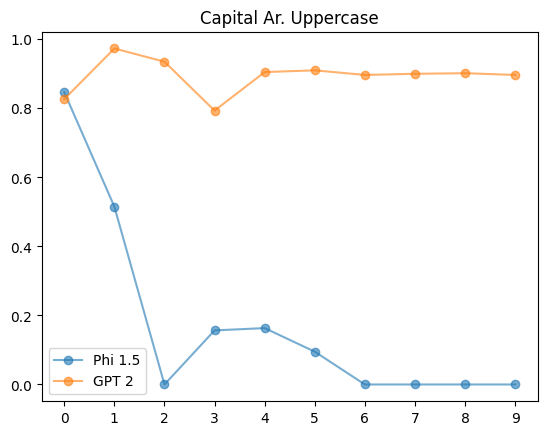

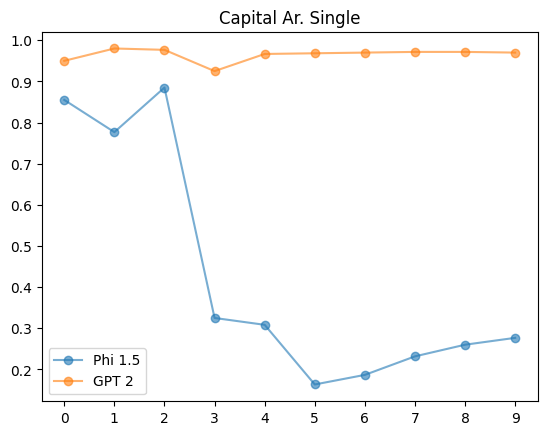

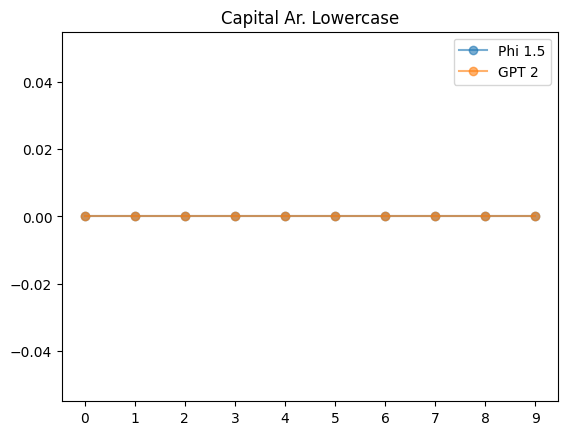

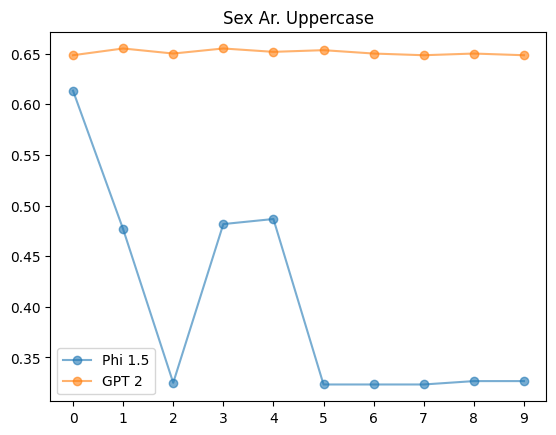

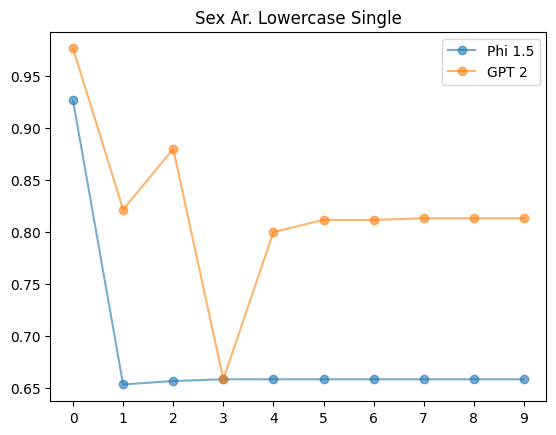

In [19]:
model_names = [model.name for model in models]
question_names = [name for name in questions.keys()]
layers = [layer for layer in tests[model_names[0]][question_names[0]].keys()]
plots = []
for question_name, quest_pair in questions.items():
    question, solution = quest_pair
    res = []
    for model in models:
        r = []
        for layer in layers:
            r.append(evaluate_batch(tests[model.name][question_name][layer], solution, out=False))
            #r.append(evaluate_batch(tests[model.name][question_name][layer], solution, out=False, score="topk", k=50))
        plt.plot(layers, r, marker='o', alpha=0.6, label=model.name)
    plt.xticks(layers)
    plt.title(question_name)
    plt.legend()
    plots.append(plt.gcf())
    plt.show()

In [20]:
#import random
#def retplot(b):
#    return plots[random.randrange(0,4)]

In [21]:
#import gradio as gr

#with gr.Blocks(analytics_enabled=False, title="Test") as demo:
#    button = gr.Radio(
#        label="Plot type",
#        choices=['scatter_plot', 'heatmap', 'us_map', 'interactive_barplot', "radial", "multiline"],
#        value='scatter_plot'
#    )
#    plot = gr.Plot(label="Plot")
#    button.change(retplot, inputs=button, outputs=[plot])
#    demo.load(retplot, inputs=[button], outputs=[plot])

#demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://386fc9b8c4db521f61.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
